In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.graph as graph
import sim_lib.graph_create as gc
import sim_lib.graph_networkx as gnx
import sim_lib.util as util

import sim_lib.attr_lib.util as attr_util

In [2]:
_N = 8

_DUNBAR = 150
_DIRECT_COST = 1
_INDIRECT_COST = 1

_CONTEXT_SWITCH_PROB = 0.25

_ATTR_COUNT = 8
_ATTR_VALUE_COUNT = 2 ** _N
_ZETA_DIST = np.random.zipf(2, _ATTR_VALUE_COUNT)
_ZETA_PROB = _ZETA_DIST / sum(_ZETA_DIST)

In [3]:
prob_func = attr_util.simple_sigmoid

In [4]:
def pick_attr(vtx, G, init=False):
    if init:
        return np.random.choice(list(range(_ATTR_VALUE_COUNT)),
                                _ATTR_COUNT, replace=False,
                                p=_ZETA_PROB)
    
    cur_contexts = G.data[vtx]
    for attr_idx in range(len(cur_contexts)):        
        if np.random.random() <= _CONTEXT_SWITCH_PROB:
            switched = False
            while not switched:
                new_context = np.random.choice(list(range(_ATTR_VALUE_COUNT)),
                                 1, p=_ZETA_PROB)
                if new_context not in cur_contexts:
                    G.data[vtx][attr_idx] = new_context
                    switched = True
                    
    return G.data[vtx]

In [5]:
# Edge selection
def has_edge(u, v, G):
    edge_prob = prob_func(u, v, G, _ZETA_PROB)
    return np.random.random() <= edge_prob

def add_edge(u, v, G):
    assert (v in u.edges) == (u in v.edges), 'connection must be symmetric'
    if not G.are_neighbors(u, v):
        G.add_edge(u, v, 1)
        
def calc_edges(G):
    edge_candidates = []
    
    for uidx in range(G.num_people - 1):
        u = G.vertices[uidx]
        
        for vidx in range(uidx + 1, G.num_people - 1):
            v = G.vertices[vidx]
            
            if has_edge(u, v, G):
                edge_candidates.append((u, v))
            elif G.are_neighbors(u, v) and not has_edge(u, v, G):
                G.remove_edge(u, v)
                
    np.random.shuffle(edge_candidates)
    for ec_u, ec_v in edge_candidates:
        add_edge(ec_u, ec_v, G)
        u_cost = attr_util.calc_cost(ec_u, _DIRECT_COST, _INDIRECT_COST, G)
        v_cost = attr_util.calc_cost(ec_v, _DIRECT_COST, _INDIRECT_COST, G)
        budget = _DUNBAR * _DIRECT_COST
        if u_cost > budget or v_cost > budget:
            G.remove_edge(u, v)

In [6]:
# Graph creation
def attribute_block_graph(n):
    vtx_set = []

    for i in range(n):
        vtx = graph.Vertex(0, 0, {0 : 0}, i)
        vtx.data = 0
        vtx_set.append(vtx)

    G = graph.Graph()
    G.vertices = vtx_set
    
    G.data = {}
    
    # Initialize contexts
    for vtx in G.vertices:
        G.data[vtx] = pick_attr(vtx, G, init=True)
    
    # Set initial edges
    calc_edges(G)
    
    return G

In [7]:
# For adding to graph
def add_attr_graph_vtx(G, v):
    v.data = 0
    G.data[v] = pick_attr(v, G, init=True)

    G.vertices.append(v)
    return v

def update_attr_dim(G):
    
    # Pick new values
    for v in G.vertices:
        v.data += 1
        G.data[v] = pick_attr(v, G)

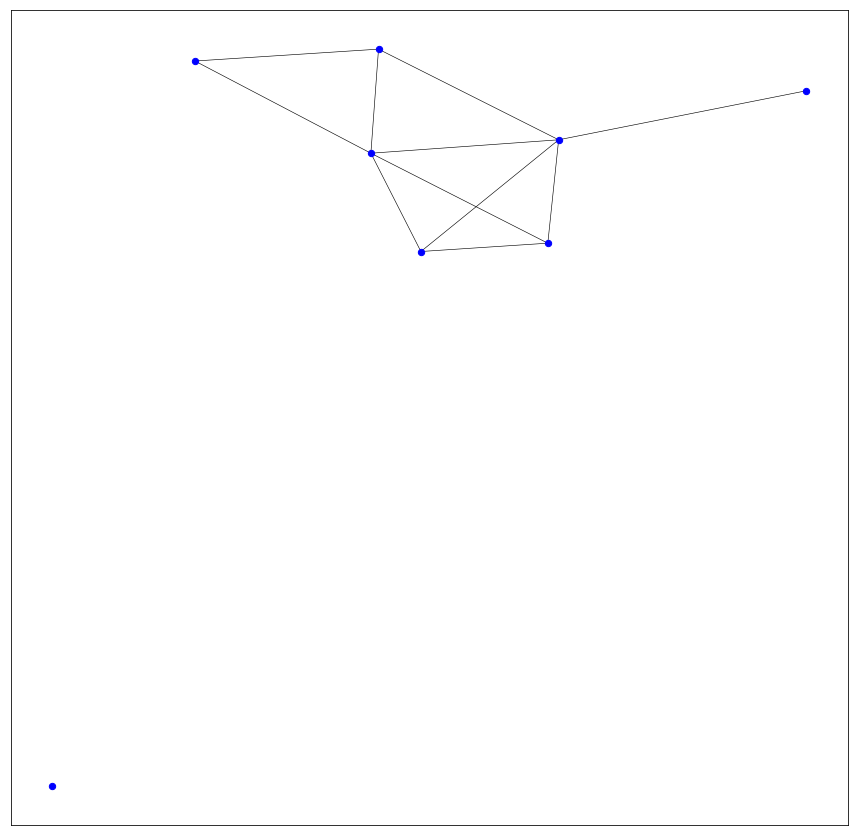

In [8]:
G_attr = attribute_block_graph(_N)

G_attr_nx = gnx.graph_to_nx(G_attr)
G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx)
plt.figure(figsize=(15,15))
nx.draw_networkx(G_attr_nx, pos=G_attr_vtx_pos, node_color='b',
                 node_size=40, width=0.6, with_labels=False)

def draw_graph(G_attr, nvtx=None):
    G_attr_nx = gnx.graph_to_nx(G_attr)
    G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx)
    
    prev_pos = G_attr_vtx_pos
    prev_nodes = G_attr_nx.nodes()
    
    colors = [ 'b' ] * len(G_attr.vertices)
    
    # Get position of new vertex
    # Calculate positions as if all new, use this position for new vertex
    if nvtx is not None:
        k_dist = 1 / (5 * np.sqrt(G_attr.num_people))
        G_attr_vtx_pos_recalc = nx.drawing.layout.spring_layout(G_attr_nx, k=k_dist)
        prev_pos[nvtx] = G_attr_vtx_pos_recalc[nvtx]

        nvtx_idx = list(G_attr_nx.nodes()).index(nvtx)
        colors[nvtx_idx] = 'r'
        
    prev_pos = nx.drawing.layout.spring_layout(G_attr_nx)
    G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx,
                                                     pos=prev_pos, fixed=prev_nodes)
    
    # Draw graph
    plt.figure(figsize=(15,15))
    nx.draw_networkx(G_attr_nx, pos=G_attr_vtx_pos, node_color=colors,
                     node_size=40, width=0.6, with_labels=None)

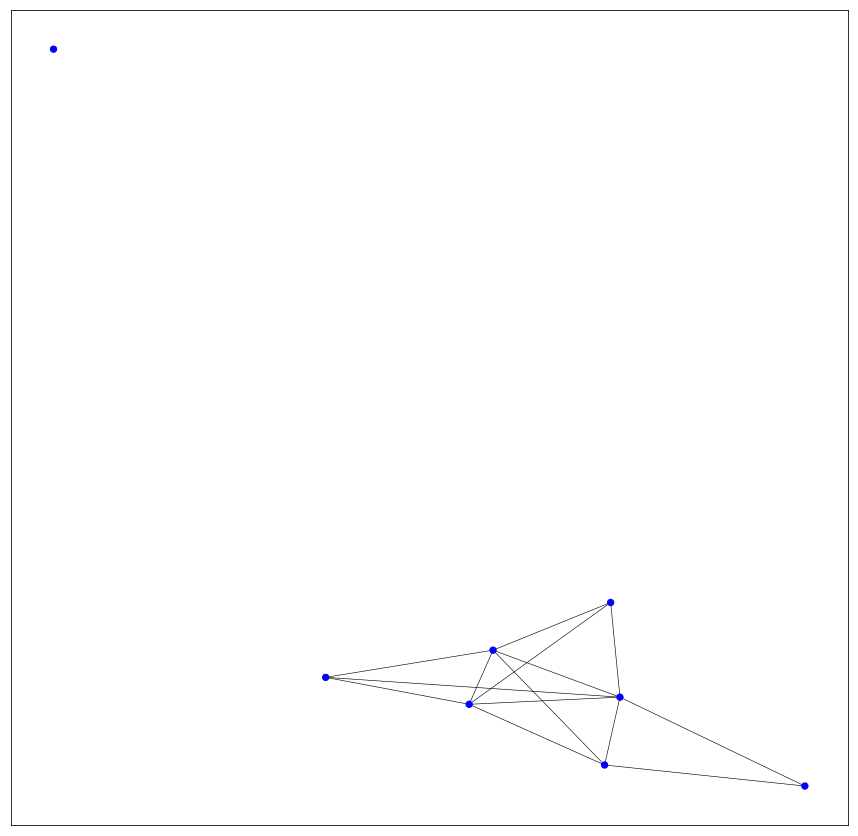

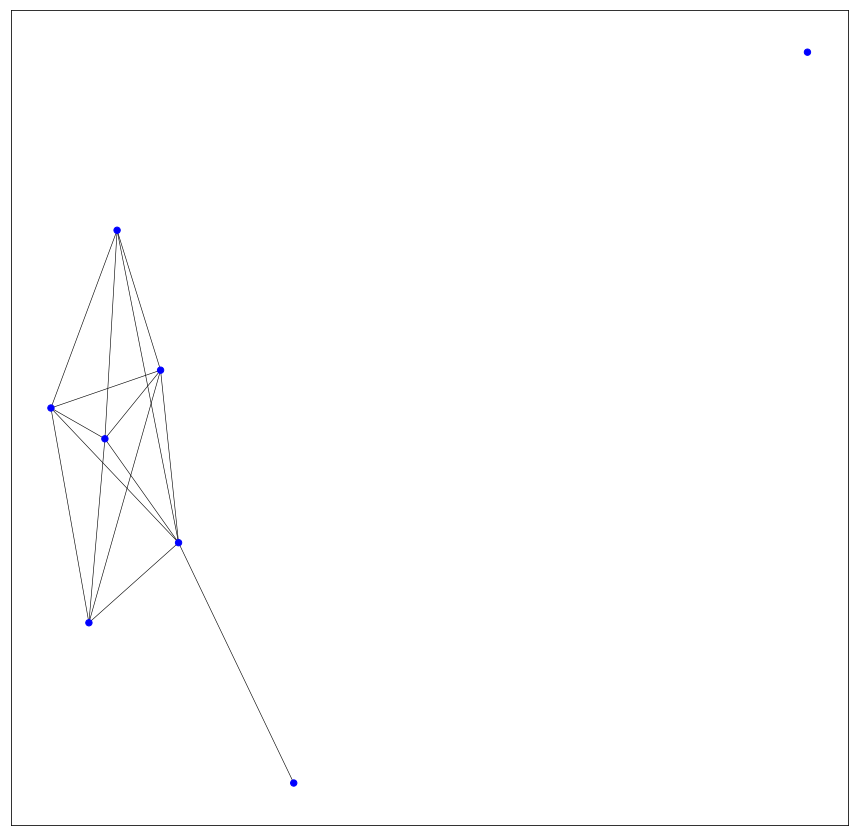

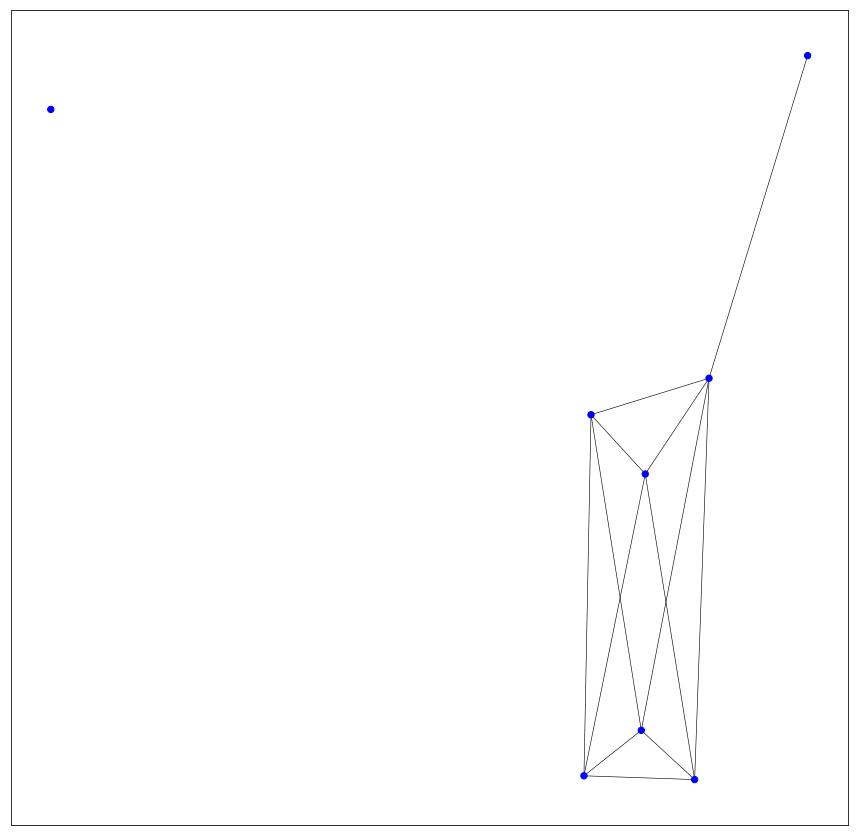

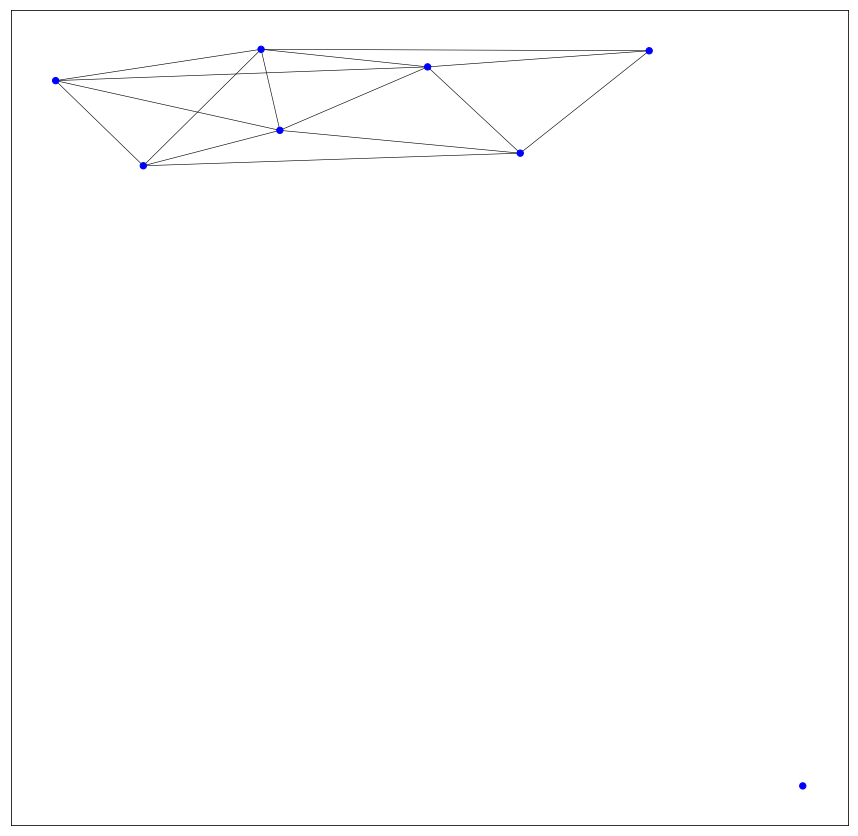

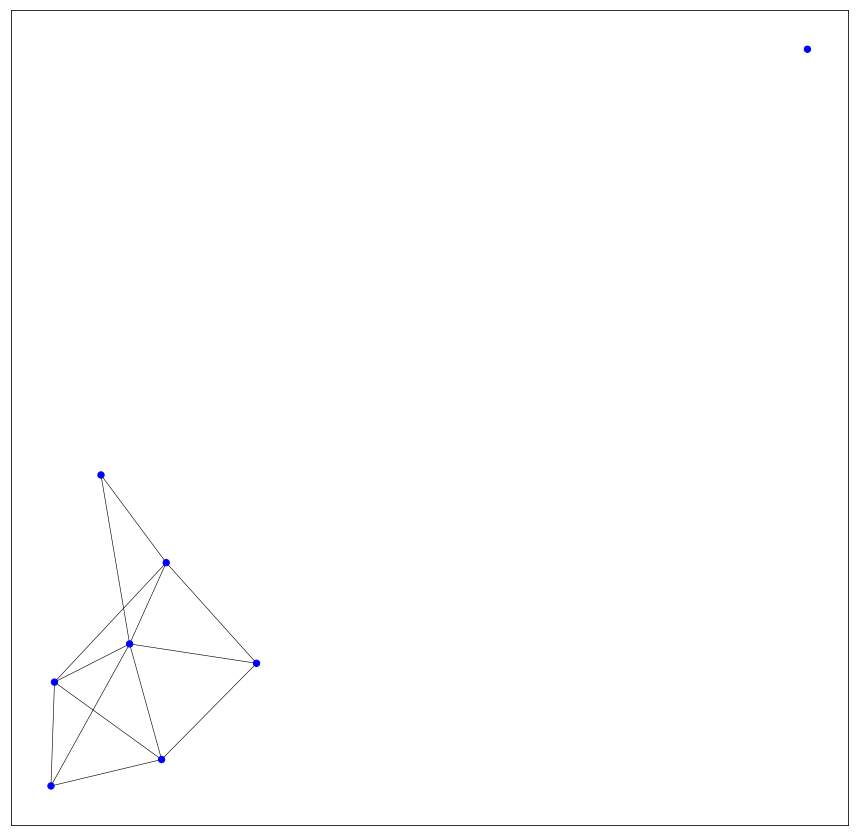

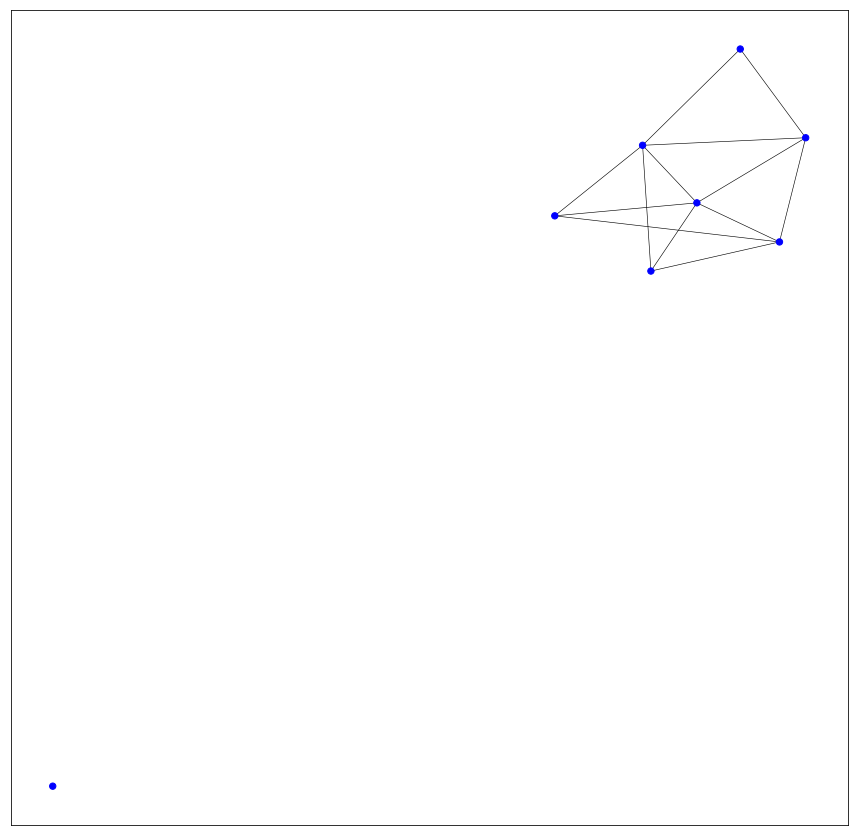

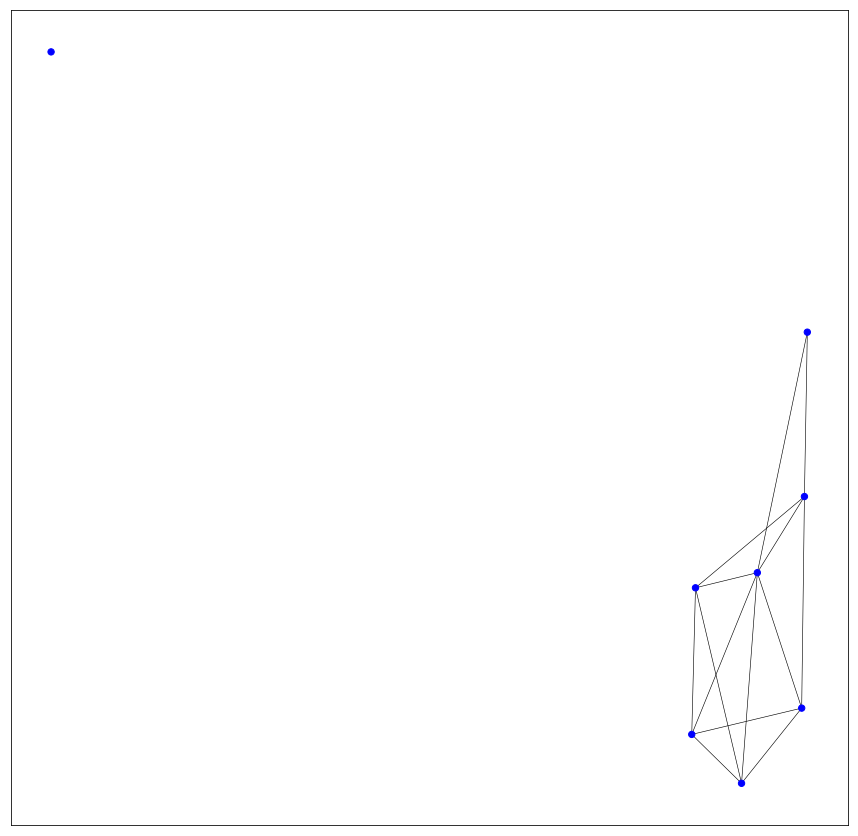

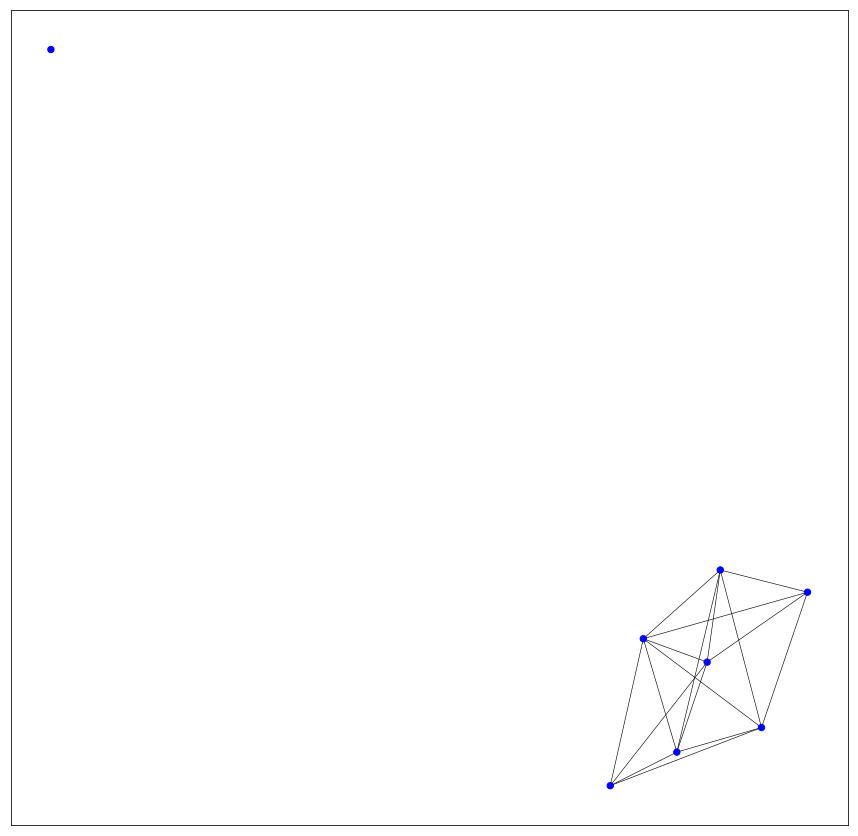

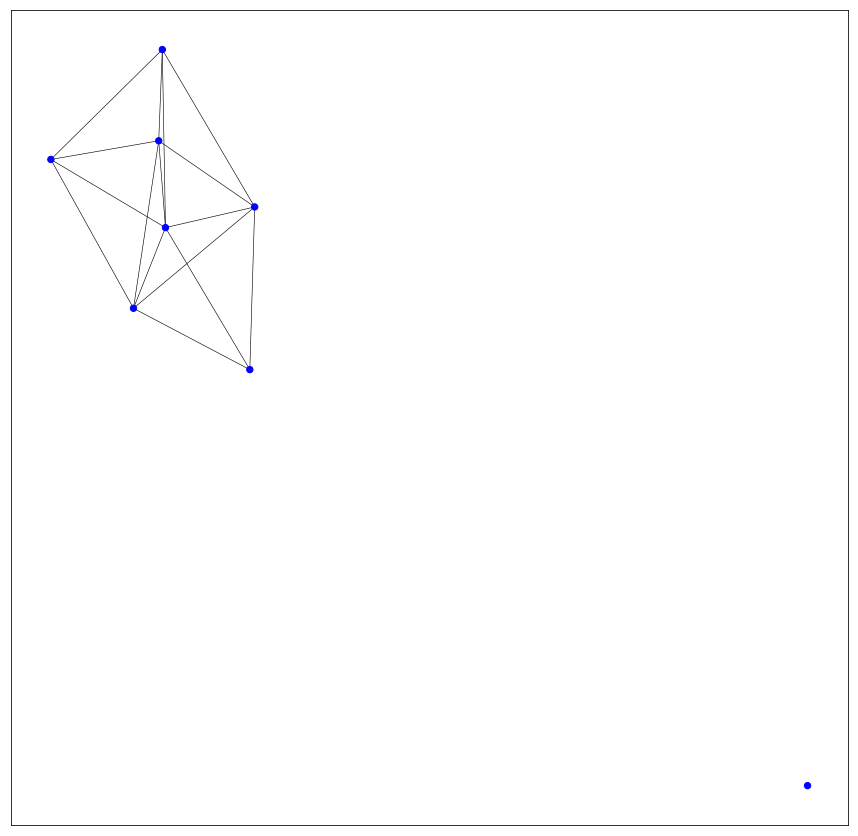

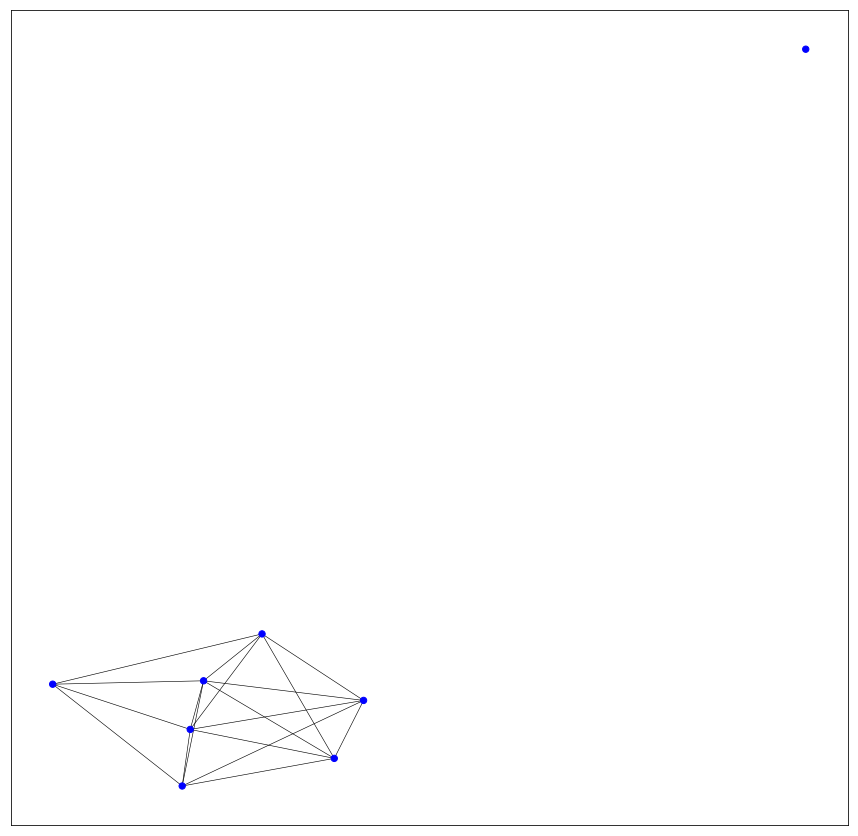

In [9]:
# Same graph multiple iters

for itr in range(10):
    
    update_attr_dim(G_attr)
    calc_edges(G_attr)
    
    draw_graph(G_attr)


In [10]:
for u in G_attr.vertices:
    for v in u.nbors:
        print(u, v, attr_util.indirect_distance(u, v, G_attr))

Vertex 0 Vertex 1 2
Vertex 0 Vertex 6 2
Vertex 0 Vertex 3 2
Vertex 0 Vertex 5 2
Vertex 0 Vertex 2 2
Vertex 1 Vertex 3 2
Vertex 1 Vertex 4 2
Vertex 1 Vertex 5 2
Vertex 1 Vertex 0 2
Vertex 2 Vertex 4 2
Vertex 2 Vertex 5 2
Vertex 2 Vertex 6 2
Vertex 2 Vertex 3 2
Vertex 2 Vertex 0 2
Vertex 3 Vertex 4 2
Vertex 3 Vertex 5 2
Vertex 3 Vertex 6 2
Vertex 3 Vertex 0 2
Vertex 3 Vertex 1 2
Vertex 3 Vertex 2 2
Vertex 4 Vertex 5 2
Vertex 4 Vertex 6 2
Vertex 4 Vertex 1 2
Vertex 4 Vertex 2 2
Vertex 4 Vertex 3 2
Vertex 5 Vertex 6 2
Vertex 5 Vertex 0 2
Vertex 5 Vertex 1 2
Vertex 5 Vertex 2 2
Vertex 5 Vertex 3 2
Vertex 5 Vertex 4 2
Vertex 6 Vertex 0 2
Vertex 6 Vertex 2 2
Vertex 6 Vertex 3 2
Vertex 6 Vertex 4 2
Vertex 6 Vertex 5 2
